## Solving an insulator system

### A quick guide to using this short julia code

We first need to include all the necessary files, which are contained in the /src folder (this has to be properly encapsulated within a module)

In [13]:
include("../src/Atoms.jl")
include("../src/scfOptions.jl")
include("../src/Ham.jl")
include("../src/hartree_pot_bc.jl")
include("../src/pseudocharge.jl")
include("../src/getocc.jl")
include("../src/anderson_mix.jl")


anderson_mix (generic function with 1 method)

We initialize some constants for the computation, in particular: the discretization step in space $dx$, the number of units, and the size of the lattice. (to check with Lin)

In [14]:
dx = 1.0;
Nunit = 32;
Lat = 10;

Furthermore we define several other variables, which need to be properly tuned. 

In [15]:
YukawaK = 0.0100; # shift for the potential evaluation
n_extra = 10;     # extra eigenvalues (above the occupation energy)
epsil0 = 10.0;
T_elec = 100;

We define $\beta = 1/T$ the inverse temperature.

In [16]:
kb = 3.1668e-6;
au2K = 315774.67;
Tbeta = au2K / T_elec;   # \beta = 1/T

We set the number of atoms in our linear molecule.

In [17]:
Ndist  = 1;  
Natoms = round(Integer, Nunit / Ndist);

We define the position of the atoms in our molecule,

In [18]:
R = zeros(Natoms, 1); # this is defined as an 2D array
for j = 1:Natoms
  R[j] = (j-0.5)*Lat*Ndist+dx;
end

and then, several fields that will be encapsulated by an Atoms struct.

In [19]:
Natoms = size(R)[1];
sigma  = ones(Natoms,1)*(2.0);  # insulator
omega  = ones(Natoms,1)*0.03;
Eqdist = ones(Natoms,1)*10.0;
mass   = ones(Natoms,1)*42000.0;
nocc   = ones(Natoms,1)*2;          # number of electrons per atom
Z      = nocc;

Now that all the fields are properly defined, we construct a "molecule" by initializing an Atoms structure as follows:

In [20]:
atoms = Atoms(Natoms, R, sigma,  omega,  Eqdist, mass, Z, nocc);

Finally, we allocate a Hamiltonian structure (Ham) that will contain all the necessary information about the system

In [21]:
H = Ham(Lat, Nunit, n_extra, dx, atoms,YukawaK, epsil0, Tbeta);

in which the Hamiltonian contains all the information to multiply it by a discretized wave function $H[\rho] \psi = \triangle \psi + \mathcal{V}_{\text{tol}}[\rho] \psi $. Now we need to compute the number of occupied states and then initilize the potentials within the Hamiltonian. 

In [22]:
# total number of occupied orbitals
Nocc = round(Integer, sum(atoms.nocc) / H.nspin);

# initialize the potentials within the Hamiltonian and setting H[\rho_0]
init_pot!(H, Nocc);

Now, we can run the self consistent iteration, which aims to solve the following non-linear eigenvalue problem

$$ \min_{\Psi^*\Psi = I \,\, \text{and} \, \,  \rho = diag(\Psi \Psi^*)} \Psi^* H[\rho] \Psi  $$

However, there is many different options within the scf iteration to solve this problem. Them all the options are enconded in a structure called scfOptions, which needs to be initializad and fed to the scf iteration. 

Within the scfOptions we need to prescribe the options for the linear eigensolver (in this case by default)

In [23]:
eigOpts = eigOptions();

and for the mixing (see the mixing notebook). In this case we use an Anderson mixing, for which we need to specify a couple of parameters.

In [24]:
betamix = 0.5;
mixdim = 10;
mixOpts = andersonMixOptions(H.Ns, betamix, mixdim );

This two options are then encapulated in a general scfOptions structure.

In [25]:
scfOpts = scfOptions(eigOpts, mixOpts);

scfOptions(1.0e-7, 100, eigOptions(1.0e-8, 100, "eigs"), andersonMixOptions([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 0.5, 10, 1))

Now, we run the scf iteration. In particular, it will modify the Hamiltonian structure, which contains all the necessary information, including $\rho$, the eigenmodes $\Psi$ among many others. 

In [26]:
# running the scf iteration
VtoterrHist = scf!(H, scfOpts);

In [27]:
using PyPlot

ploting the eigenvalues for the insulator

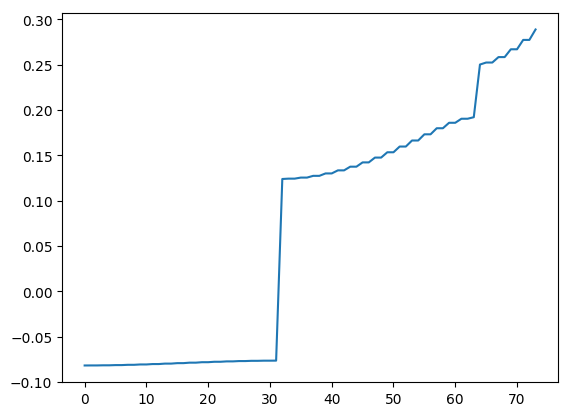

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1273d4b10>

In [28]:
plot(H.ev)